In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 1000
errIndex = 0
betx = 1.9065054393933862
alfx = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
n_particles = 40000
nx = 0
NL_t = 0.4
NL_c = 0.01

In [3]:
# H1 = 0.04005207 

# 1. Preparation

In [4]:
beam, lattice = impact.readInputFile('test_IOTA.in')

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.n_particles = n_particles

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

### 1.2. generate particles

##### 1.2.1. generate pData

In [6]:
beamtmp = copy(beam)
beamtmp.distribution.distribution_type = 'IOTA_Waterbag'
beamtmp.distribution.NL_t = NL_t
beamtmp.distribution.NL_c = NL_c
impact.writeInputFile(beamtmp,[]);
impact.run(beamtmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

##### 1.2.2. check pData

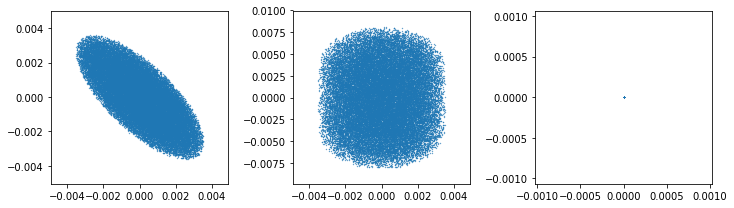

In [7]:
pData = impact.readParticleData(-111110,ke,mass,freq)
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pData[:,0],pData[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pData[:,4],pData[:,5],s=0.1)
plt.tight_layout()

##### 1.2.3. generate testP

In [8]:
testP = 0.0
sig = 0.01
k=0
q_m = beamtmp.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-0.01,0.01,nx):
    for y in np.linspace(-0.01,0.01,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            
            
pTest = np.array(pTest)
nptTest = len(pTest)
print('initial npt=',nptTest)

initial npt= 0


##### 1.2.4. combine pData, pTest  and Check

In [9]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

(40000, 9)


In [10]:
beam.n_particles = n_particles + nptTest
impact.writeInputFile(beam,[]);
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

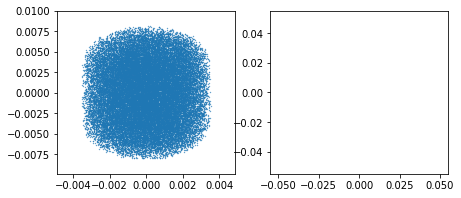

In [11]:
pData = impact.readParticleData(-111110, ke, mass, freq)
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.scatter(pData[nptTest:,0],pData[nptTest:,2],s=0.1);
plt.subplot(1,2,2)
plt.scatter(pData[:nptTest,0],pData[:nptTest,2],s=0.1);

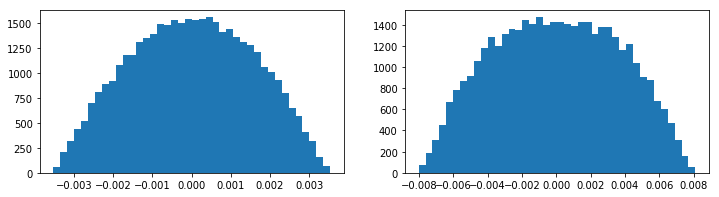

In [12]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(pData[:,0],bins=40);
plt.subplot(1,2,2)
plt.hist(pData[:,2],bins=40);

In [13]:
L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

39.968229715800106


### 1.3 adjust lattice

In [14]:
lattice[0].turns = nTurn

for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = ceil(lattice[i].length*30)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_sckick = ceil(lattice[i].length*60)
            lattice[i].n_map = 5
        else:
            lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]

In [15]:
L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

39.968229715800106


# 2. Run

In [16]:
print('===========================')
print('=========== run ===========')
print('===========================')

=========== run ===========


In [17]:
impact.writeInputFile(beam,lattice) 
# impact.run(beam)

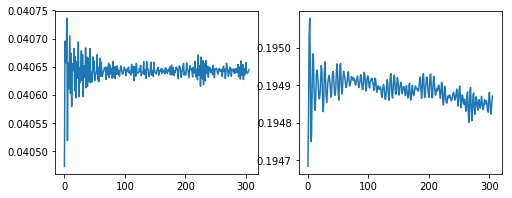

In [28]:
Inv = np.loadtxt('fort.81')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Inv[:,1])
plt.subplot(1,2,2)
plt.plot(Inv[:,2])

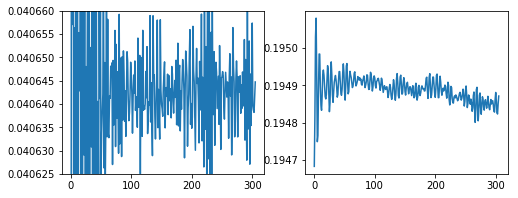

In [29]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Inv[:,1])
plt.ylim(0.040645-0.00002,0.040645+0.000015)
plt.subplot(1,2,2)
plt.plot(Inv[:,2])